<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/supplements/pytorch_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Introduction to PyTorch

We show some simple examples of how to use PyTorch. 
For a more detailed introduction see the free [Deep Learning With PyTorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf) book.
See also the [official tutorials](https://pytorch.org/tutorials) for more info.




In [2]:
import sklearn
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
from functools import partial

import os

import numpy as np
from scipy.special import logsumexp
np.set_printoptions(precision=3)




In [3]:


import torch
import torchvision
print("torch version {}".format(torch.__version__))
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print("current device {}".format(torch.cuda.current_device()))
else:
  print("Torch cannot find GPU")

def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#torch.backends.cudnn.benchmark = True

torch version 1.8.0+cu101
Tesla P100-PCIE-16GB
current device 0


# Automatic differentiation <a class="anchor" id="AD"></a>



## Binary logistic regression

In this section, we illustrate how to use autograd to compute the gradient and Hessian of the negative log likelihood for binary logistic regression.
(See also [the JAX optimization colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/supplements/opt.ipynb).)


First we fit the model using sklearn to a (two-class version of) the Iris dataset. We will then compare to this later.

In [4]:
# Fit the model usign sklearn

import sklearn.datasets
from sklearn.model_selection import train_test_split

iris = sklearn.datasets.load_iris()
X = iris["data"]
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0'
N, D = X.shape # 150, 4

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

from sklearn.linear_model import LogisticRegression

# We set C to a large number to turn off regularization.
# We don't fit the bias term to simplify the comparison below.
log_reg = LogisticRegression(solver="lbfgs", C=1e5, fit_intercept=False)
log_reg.fit(X_train, y_train)
w_mle_sklearn = np.ravel(log_reg.coef_)
print(w_mle_sklearn)

[-4.414 -9.111  6.539 12.686]


In [5]:


# Binary cross entropy
def BCE_with_logits(logits, targets):
    N = logits.shape[0]
    logits = logits.reshape(N,1)
    logits_plus = np.hstack([np.zeros((N,1)), logits]) # e^0=1
    logits_minus = np.hstack([np.zeros((N,1)), -logits])
    logp1 = -logsumexp(logits_minus, axis=1)
    logp0 = -logsumexp(logits_plus, axis=1)
    logprobs = logp1 * targets + logp0 * (1-targets)
    return -np.sum(logprobs)/N

# Compute using numpy
def sigmoid(x): return 0.5 * (np.tanh(x / 2.) + 1)

def predict_logit(weights, inputs):
    return np.dot(inputs, weights) # Already vectorized

def predict_prob(weights, inputs):
    return sigmoid(predict_logit(weights, inputs))

def NLL(weights, batch):
    X, y = batch
    logits = predict_logit(weights, X)
    return BCE_with_logits(logits, y)

def NLL_grad(weights, batch):
    X, y = batch
    N = X.shape[0]
    mu = predict_prob(weights, X)
    g = np.sum(np.dot(np.diag(mu - y), X), axis=0)/N
    return g



In [40]:
w_np = w_mle_sklearn
y_pred = predict_prob(w_np, X_test)
loss_np = NLL(w_np, (X_test, y_test))
grad_np = NLL_grad(w, (X_test, y_test))
print("params {}".format(w_np))
#print("pred {}".format(y_pred))
print("loss {}".format(loss_np))
print("grad {}".format(grad_np))

params [-4.414 -9.111  6.539 12.686]
loss 0.11824007099618833
grad [-0.235 -0.122 -0.198 -0.064]


## PyTorch code

To compute the gradient using torch, we proceed as follows.

- declare all the variables that you want to take derivatives with respect to using the requires_grad=True argumnet
- define the (scalar output) objective function you want to differentiate in terms of these variables, and evaluate it at a point. This will generate a computation graph and store all the tensors.
- call objective.backward() to trigger backpropagation (chain rule) on this graph.
- extract the gradients from each variable using variable.grad field. (These will be torch tensors.)

See the example below.

In [41]:

# data. By default, numpy uses double but torch uses float
X_train_t = torch.tensor(X_train,  dtype=torch.float)
y_train_t = torch.tensor(y_train, dtype=torch.float)

X_test_t = torch.tensor(X_test, dtype=torch.float)
y_test_t = torch.tensor(y_test, dtype=torch.float)

In [8]:
# parameters
W = np.reshape(w_mle_sklearn, [D, 1]) # convert 1d vector to 2d matrix
w_torch = torch.tensor(W, requires_grad=True, dtype=torch.float)
#w_torch.requires_grad_() 
print(w_torch)


# logistic regression in one line of code
# This returns Nx1 probabilities
y_pred = torch.sigmoid(torch.matmul(X_test_t, w_torch))[:,0]



tensor([[-4.4138],
        [-9.1106],
        [ 6.5387],
        [12.6857]], requires_grad=True)


In [9]:
# loss function is average NLL
criterion = torch.nn.BCELoss(reduction='mean')
loss_torch = criterion(y_pred, y_test_t)

print(loss_torch)

tensor(0.1182, grad_fn=<BinaryCrossEntropyBackward>)


In [10]:

# Backprop
#if w_torch.grad is not None:    
#  w_torch.grad.zero_()
loss_torch.backward()
print(w_torch.grad)
grad_torch = w_torch.grad[:,0].cpu().numpy()



tensor([[-0.2353],
        [-0.1223],
        [-0.1976],
        [-0.0638]])


In [11]:
# Test
assert np.allclose(grad_np, grad_torch)

print("loss {}".format(loss_torch))
print("grad {}".format(grad_torch))

loss 0.11824005842208862
grad [-0.235 -0.122 -0.198 -0.064]


# Stochastic optimization using SGD

## DataLoader

First we need a way to get minbatches of data.

In [34]:

from torch.utils.data import DataLoader, TensorDataset

# To make things interesting, we pick a batchsize of B=33, which is not divisible by N=100
dataset = TensorDataset(X_train_t, y_train_t)
B = 33
dataloader = DataLoader(dataset, batch_size=B, shuffle=True)
print(X_train_t.shape)
print('{} examples divided into {} batches of size {}'.format(
    len(dataloader.dataset), len(dataloader), dataloader.batch_size))

for i, batch in enumerate(dataloader):
  X, y = batch
  print(X.shape)
  print(y.shape)
 

torch.Size([100, 4])
100 examples divided into 4 batches of size 33
torch.Size([33, 4])
torch.Size([33])
torch.Size([33, 4])
torch.Size([33])
torch.Size([33, 4])
torch.Size([33])
torch.Size([1, 4])
torch.Size([1])


In [23]:
datastream = iter(dataloader)
for i in range(3):
  X,y = next(datastream)
  print(y)

tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.])


## Vanilla SGD training loop

In [14]:
def predict(X, w):
  y_pred = torch.sigmoid(torch.matmul(X, w))[:,0]
  return y_pred


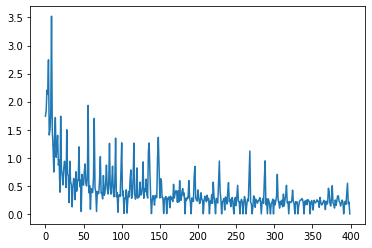

In [42]:
set_seed(0)
params = torch.randn((D,1), requires_grad=True)
nepochs = 100
nbatches = len(dataloader)
criterion = torch.nn.BCELoss(reduction='mean')
learning_rate = 1e-1
loss_trace = []

for epoch in range(nepochs):
  for b, batch in enumerate(dataloader):
    X, y =  batch

    if params.grad is not None:
      params.grad.zero_() # reset gradient to zero
    y_pred = predict(X, params)
    loss = criterion(y_pred, y)
    #print(f'epoch {epoch}, batch {b}, loss: {loss.item()}')
    loss_trace.append(loss)

    loss.backward()
    with torch.no_grad():
      params -= learning_rate * params.grad
  
  #print(f'end of epoch {epoch}, loss: {loss.item()}')
    
plt.figure()
plt.plot(loss_trace)


In [39]:

print("parameters from sklearn {}".format(w_mle_sklearn))
print("parameters from torch {}".format(params[:,0]))

parameters from sklearn [-4.414 -9.111  6.539 12.686]
parameters from torch-bfgs tensor([-0.8046, -2.3841,  1.3471,  2.9677], grad_fn=<SelectBackward>)


In [51]:

y_pred_np = predict_prob(w_np, X_test)
y_pred_t = predict(X_test_t, params) 
y_pred = y_pred_t.detach().numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(y_pred_np)
print(y_pred)
#['{:0.2f}'.format(p) for p in y_pred_np]
#print('{:0.2f}'.format(y_pred))


[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
[0.156 0.000 0.976 0.227 0.179 0.000 0.062 0.680 0.570 0.092 0.487 0.000
 0.000 0.000 0.000 0.135 0.877 0.125 0.207 0.904 0.000 0.471 0.000 0.876
 0.298 0.784 0.859 0.842 0.000 0.000 0.000 0.000 0.063 0.000 0.000 0.793
 0.094 0.000 0.000 0.000 0.803 0.107 0.119 0.000 0.000 0.100 0.396 0.553
 0.085 0.779]


## Use Torch SGD optimizer

parameters from sklearn [-4.414 -9.111 6.539 12.686]
parameters from torch tensor([-0.8046, -2.3841,  1.3471,  2.9677], grad_fn=<SelectBackward>)


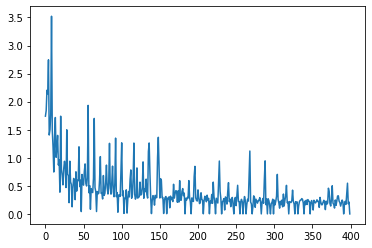

In [66]:
set_seed(0)
params = torch.randn((D,1), requires_grad=True)
nepochs = 100
nbatches = len(dataloader)
criterion = torch.nn.BCELoss(reduction='mean')
learning_rate = 1e-1
loss_trace = []

optimizer = torch.optim.SGD([params], lr=learning_rate)
    
for epoch in range(nepochs):
  for b, batch in enumerate(dataloader):
    X, y =  batch

    y_pred = predict(X, params)
    loss = criterion(y_pred, y)
    #print(f'epoch {epoch}, batch {b}, loss: {loss.item()}')
    loss_trace.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  #print(f'end of epoch {epoch}, loss: {loss.item()}')
    
plt.figure()
plt.plot(loss_trace)

print("parameters from sklearn {}".format(w_mle_sklearn))
print("parameters from torch {}".format(params[:,0]))

parameters from sklearn [-4.414 -9.111 6.539 12.686]
parameters from torch tensor([-0.3577, -3.1933,  0.4717,  5.1280], grad_fn=<SelectBackward>)


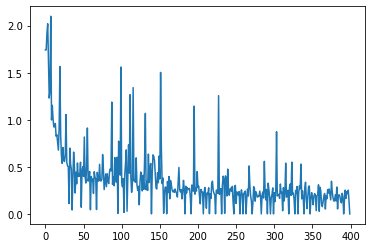

In [67]:
set_seed(0)
params = torch.randn((D,1), requires_grad=True)
nepochs = 100
nbatches = len(dataloader)
criterion = torch.nn.BCELoss(reduction='mean')
learning_rate = 1e-1
loss_trace = []

optimizer = torch.optim.Adam([params], lr=learning_rate)
    
for epoch in range(nepochs):
  for b, batch in enumerate(dataloader):
    X, y =  batch

    y_pred = predict(X, params)
    loss = criterion(y_pred, y)
    #print(f'epoch {epoch}, batch {b}, loss: {loss.item()}')
    loss_trace.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  #print(f'end of epoch {epoch}, loss: {loss.item()}')
    
plt.figure()
plt.plot(loss_trace)

print("parameters from sklearn {}".format(w_mle_sklearn))
print("parameters from torch {}".format(params[:,0]))

In [68]:

y_pred_np = predict_prob(w_np, X_test)
y_pred_t = predict(X_test_t, params) 
y_pred = y_pred_t.detach().numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(y_pred_np)
print(y_pred)
#['{:0.2f}'.format(p) for p in y_pred_np]
#print('{:0.2f}'.format(y_pred))

[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
[0.060 0.000 0.982 0.169 0.127 0.000 0.052 0.862 0.639 0.063 0.529 0.000
 0.000 0.000 0.000 0.086 0.892 0.075 0.101 0.937 0.000 0.445 0.000 0.898
 0.156 0.906 0.830 0.873 0.000 0.000 0.000 0.000 0.046 0.000 0.000 0.866
 0.063 0.000 0.000 0.000 0.810 0.064 0.084 0.000 0.000 0.060 0.250 0.410
 0.064 0.836]


# Batch optimization using BFGS

We will use BFGS from PyTorch for fitting a logistic regression model, and compare to sklearn.

In [63]:
set_seed(0)
params = torch.randn((D,1), requires_grad=True)
optimizer = torch.optim.LBFGS([params], history_size=10)
    
def closure():
    optimizer.zero_grad()
    y_pred = predict(X_train_t, params)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    return loss

max_iter = 10
for i in range(max_iter):
    loss = optimizer.step(closure)
    print(loss.item())

1.994707465171814
0.06939578056335449
0.06907700002193451
0.06907700002193451
0.06907700002193451
0.06907700002193451
0.06907700002193451
0.06907700002193451
0.06907700002193451
0.06907700002193451


In [61]:
print("parameters from sklearn {}".format(w_mle_sklearn))
print("parameters from torch {}".format(params[:,0]))

parameters from sklearn [-4.414 -9.111 6.539 12.686]
parameters from torch tensor([-4.4146, -9.1144,  6.5401, 12.6912], grad_fn=<SelectBackward>)


In [64]:

y_pred_np = predict_prob(w_np, X_test)
y_pred_t = predict(X_test_t, params) 
y_pred = y_pred_t.detach().numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(y_pred_np)
print(y_pred)
#['{:0.2f}'.format(p) for p in y_pred_np]
#print('{:0.2f}'.format(y_pred))

[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]


# Modules

We can define logistic regression as a one layer MLP.
This encapsulates the parameters inside the model.

In [69]:
# Define model and loss.

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(D, 1, bias=False) 
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred[:,0] # (N,1) -> (N)
    
set_seed(0)
model = Model() 




In [70]:
optimizer = torch.optim.LBFGS(model.parameters(), history_size=10)
    
criterion = torch.nn.BCELoss(reduction='mean')
def closure():
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    #print('loss:', loss.item())
    loss.backward()
    return loss

max_iter = 10
for i in range(max_iter):
    loss = optimizer.step(closure)

params = list(model.parameters())
w_torch_bfgs = params[0][0].detach().numpy() #(D,) vector
print("parameters from sklearn {}".format(w_mle_sklearn))
print("parameters from torch-bfgs {}".format(w_torch_bfgs))

parameters from sklearn [-4.414 -9.111 6.539 12.686]
parameters from torch-bfgs [-4.415 -9.114 6.540 12.691]
